# **TP : Implémentation d’un Perceptron Multicouche (MLP) pour Résoudre le Probléme XOR**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

**1) Données XOR (binaire)**

In [2]:
X = torch.tensor([[0.,0.],
                  [0.,1.],
                  [1.,0.],
                  [1.,1.]], dtype=torch.float32)
y = torch.tensor([[0.],
                  [1.],
                  [1.],
                  [0.]], dtype=torch.float32)


**2) Modèle MLP**

In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=2, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),            # ou ReLU/Sigmoid ; Tanh marche très bien pour XOR
            nn.Linear(hidden, out_dim)  # sortie = logit
        )
    def forward(self, x):
        return self.net(x)

model = MLP()

**3) Perte et Optimiseur**

In [5]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

**4) Entraînement**

In [12]:
torch.manual_seed(0)
n_epochs = 2000

for epoch in range(1, n_epochs+1):
    optimizer.zero_grad()
    logits = model(X)           
    loss = criterion(logits, y)   
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        with torch.no_grad():
            prob = torch.sigmoid(logits)
            pred = (prob >= 0.5).float()
            acc  = (pred.eq(y)).float().mean().item()
        print(f"Epoch {epoch:4d} | loss={loss.item():.6f} | acc={acc*100:.1f}%")


Epoch  200 | loss=0.000893 | acc=100.0%
Epoch  400 | loss=0.000843 | acc=100.0%
Epoch  600 | loss=0.000799 | acc=100.0%
Epoch  800 | loss=0.000759 | acc=100.0%
Epoch 1000 | loss=0.000723 | acc=100.0%
Epoch 1200 | loss=0.000690 | acc=100.0%
Epoch 1400 | loss=0.000660 | acc=100.0%
Epoch 1600 | loss=0.000633 | acc=100.0%
Epoch 1800 | loss=0.000607 | acc=100.0%
Epoch 2000 | loss=0.000584 | acc=100.0%


**5) Évaluation finale**

In [13]:
with torch.no_grad():
    logits = model(X)
    prob = torch.sigmoid(logits)
    pred = (prob >= 0.5).float()
    print("\nEntrée  ->  Cible  /  Probabilité (classe 1)  /  Prédiction")
    for xi, yi, pi, pr in zip(X, y, prob, pred):
        print(f"{xi.numpy()} -> {int(yi.item())} / {pi.item():.3f} / {int(pr.item())}")


Entrée  ->  Cible  /  Probabilité (classe 1)  /  Prédiction
[0. 0.] -> 0 / 0.001 / 0
[0. 1.] -> 1 / 1.000 / 1
[1. 0.] -> 1 / 1.000 / 1
[1. 1.] -> 0 / 0.001 / 0


**Visualiser la frontière de décision**

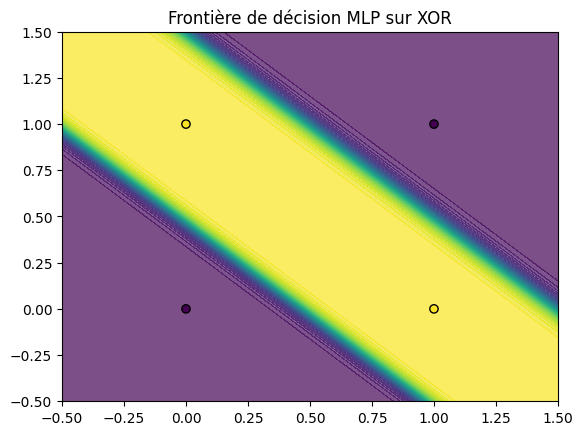

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# grille
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200), np.linspace(-0.5,1.5,200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    zz = torch.sigmoid(model(grid)).reshape(xx.shape).numpy()

plt.contourf(xx, yy, zz, levels=50, alpha=0.7)
plt.scatter(X[:,0], X[:,1], c=y.squeeze(), edgecolor='k')
plt.title("Frontière de décision MLP sur XOR")
plt.show()


# **Classification binaire avec un réseau de neurones**

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt


# Configuration reproductible
torch.manual_seed(42)
np.random.seed(42)

**Architecture MLP**

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

**Chargement et prétraitement des données**

In [21]:
def load_data():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
               'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']
    
    data = pd.read_csv(url, names=columns)
    
    # Remplacer les 0 par NaN dans les colonnes pertinentes
    cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    data[cols_to_fix] = data[cols_to_fix].replace(0, np.nan)
    
    # Imputation par la médiane
    for col in cols_to_fix:
        data[col].fillna(data[col].median(), inplace=True)
    
    # Séparation des features et de la target
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values
    
    # Normalisation
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

# Préparation des données
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Conversion en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Création des DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

/tmp/ipykernel_36/3644956546.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [22]:
# Initialisation du modèle
input_size = X_train.shape[1]
model = NeuralNetwork(
    input_size=input_size,
    hidden_size1=12,
    hidden_size2=8
)

In [23]:
# Fonction de coût et optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Entraînement**

In [24]:
num_epochs = 150
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    
    # Calcul de la perte moyenne pour l'époque
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [50/150], Loss: 0.3991
Epoch [100/150], Loss: 0.3696
Epoch [150/150], Loss: 0.3493


**Évaluation**

In [25]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_preds.extend(predicted.view(-1).tolist())
        all_targets.extend(targets.view(-1).tolist())

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 79.22%


In [26]:
# Exemple de prédiction
sample = X_test[0:1]
prediction = model(sample)
print(f"\nExemple de prédiction: {prediction.item():.4f} => {'Diabétique' if prediction > 0.5 else 'Non-diabétique'}")


Exemple de prédiction: 0.7535 => Diabétique


**ajustements d'architecture et d'hyperparamètres pour de meilleures performances**

In [31]:
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(ImprovedNeuralNetwork, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(32, 24),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(24, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [30]:
# Chargement et prétraitement amélioré
def load_data():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
               'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']
    
    data = pd.read_csv(url, names=columns)
    
    # Séparation features/target
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values
    
    # Imputation des valeurs manquantes
    imputer = SimpleImputer(missing_values=0, strategy='median')
    cols_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    data[cols_to_impute] = imputer.fit_transform(data[cols_to_impute])
    
    # Normalisation robuste
    for col in cols_to_impute:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        data[col] = (data[col] - data[col].median()) / iqr
    
    # Ajout de caractéristiques polynomiales
    data['Glucose_BMI'] = data['Glucose'] * data['BMI']
    data['Age_Insulin'] = data['Age'] * data['Insulin']
    
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values
    
    return X, y

# Préparation des données
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Normalisation finale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Création des DataLoader avec validation set
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [32]:
# Initialisation du modèle
model = ImprovedNeuralNetwork(input_size=X_train.shape[1])

# Fonction de coût et optimiseur avec weight decay
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
# Entraînement avec early stopping
num_epochs = 300
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience, counter = 15, 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    
    # Calcul de la perte moyenne pour l'époque
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    # Mise à jour du scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [20/300], Train Loss: 0.4696, Val Loss: 0.4640
Early stopping at epoch 37


In [34]:
# Évaluation finale
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        all_probs.extend(outputs.view(-1).tolist())
        all_preds.extend(predicted.view(-1).tolist())
        all_targets.extend(targets.view(-1).tolist())

accuracy = 100 * correct / total
print(f'\nFinal Accuracy on test set: {accuracy:.2f}%')


Final Accuracy on test set: 73.28%


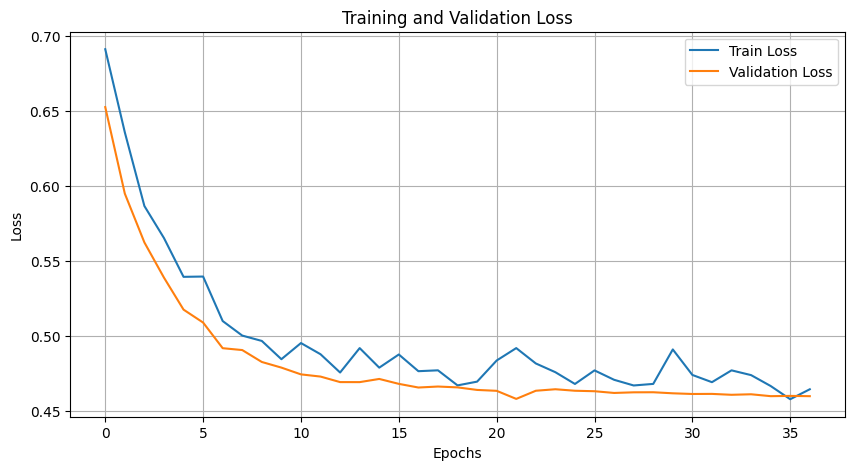

In [35]:
# Courbes d'apprentissage
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Classification des Caractères Tifinagh avec un Réseau de Neurones Multiclasses**

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from torch.cuda.amp import autocast, GradScaler
import re
from sklearn.preprocessing import StandardScaler

In [2]:
IMAGE_MODE = 'grayscale'  # 'grayscale' ou 'rgb'
TARGET_SIZE = (32, 32)  # Taille des images redimensionnées
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Vérification GPU
print(f"Device: {DEVICE}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

Device: cuda
GPU available: True
GPU name: Tesla T4
Number of GPUs: 2


Préparer les données

In [4]:
# Définir le chemin vers le dossier décompressé
data_dir = '/kaggle/input/amhcd-gryscale/amhcd-data-64/tifinagh-images'
print(data_dir)

# Charger le fichier CSV contenant les étiquettes
try:
    # Read the CSV file
    labels_df = pd.read_csv('/kaggle/input/amhcd-gryscale/amhcd-data-64/labels-map.csv', 
                           header=None, names=['image_path', 'label'])
    
    # Fix the paths in the CSV
    labels_df['image_path'] = labels_df['image_path'].apply(
        lambda x: os.path.join(data_dir, x.replace('./images-data-64/tifinagh-images/', '')))
    
    print("DataFrame preview after path correction:")
    print(labels_df.head())
    
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, \
           "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")
    # Alternative: construire un DataFrame à partir des dossiers
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp')):
                    image_paths.append(os.path.join(label_path, img_name))
                    labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

/kaggle/input/amhcd-gryscale/amhcd-data-64/tifinagh-images
DataFrame preview after path correction:
                                          image_path label
0  /kaggle/input/amhcd-gryscale/amhcd-data-64/tif...     ⴰ
1  /kaggle/input/amhcd-gryscale/amhcd-data-64/tif...     ⴰ
2  /kaggle/input/amhcd-gryscale/amhcd-data-64/tif...     ⴰ
3  /kaggle/input/amhcd-gryscale/amhcd-data-64/tif...     ⴰ
4  /kaggle/input/amhcd-gryscale/amhcd-data-64/tif...     ⴰ
Loaded 28182 samples with 33 unique classes.


**l'architecture du MLP**

In [5]:
# Classe Dataset personnalisée
class TifinaghDataset(Dataset):
    def __init__(self, image_paths, labels, mode='rgb', transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            if self.mode == 'grayscale':
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    raise ValueError(f"Could not load image: {img_path}")
                image = cv2.resize(image, TARGET_SIZE)
                image = image.astype(np.float32) / 255.0
                image = np.expand_dims(image, axis=0)  # Ajouter une dimension de canal
            else:  # RGB
                image = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if image is None:
                    raise ValueError(f"Could not load image: {img_path}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, TARGET_SIZE)
                image = image.astype(np.float32) / 255.0
                image = np.transpose(image, (2, 0, 1))  # Changement de format HWC vers CHW
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            # Create a blank image as fallback
            if self.mode == 'grayscale':
                image = np.zeros((1, *TARGET_SIZE), dtype=np.float32)
            else:
                image = np.zeros((3, *TARGET_SIZE), dtype=np.float32)
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [6]:
class TifinaghMLP(nn.Module):
    def __init__(self, input_size, num_classes, channels=1):
        super(TifinaghMLP, self).__init__()
        self.flatten = nn.Flatten()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

In [7]:
image_paths = labels_df['image_path'].values
labels = labels_df['label_encoded'].values

# Diviser en ensembles d'entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Créer les datasets
train_dataset = TifinaghDataset(X_train, y_train, mode=IMAGE_MODE)
val_dataset = TifinaghDataset(X_val, y_val, mode=IMAGE_MODE)
test_dataset = TifinaghDataset(X_test, y_test, mode=IMAGE_MODE)

# Créer les DataLoaders avec optimisation pour GPU
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True)

**Entraînement**

In [8]:
# Calculer la taille d'entrée
if IMAGE_MODE == 'grayscale':
    input_size = TARGET_SIZE[0] * TARGET_SIZE[1]
else:
    input_size = TARGET_SIZE[0] * TARGET_SIZE[1] * 3

# Initialiser le modèle avec support multi-GPU
model = TifinaghMLP(input_size, num_classes)

# Utiliser multi-GPU si disponible
if torch.cuda.device_count() > 1:
    print(f"Utilisation de {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(DEVICE)

# Initialiser la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initialiser le scaler pour mixed precision training
scaler = GradScaler()

Utilisation de 2 GPUs!


/tmp/ipykernel_36/2447033918.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
# Entraînement avec mixed precision
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Phase d'entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass avec scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Phase de validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Afficher l'utilisation de la mémoire GPU
        if torch.cuda.is_available():
            print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

/tmp/ipykernel_36/2619919109.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100], Train Loss: 0.4116, Train Acc: 86.20%, Val Loss: 0.2683, Val Acc: 91.45%
GPU Memory allocated: 0.03 GB
Epoch [11/100], Train Loss: 0.1955, Train Acc: 93.46%, Val Loss: 0.1266, Val Acc: 95.62%
GPU Memory allocated: 0.03 GB
Epoch [21/100], Train Loss: 0.1475, Train Acc: 95.09%, Val Loss: 0.1125, Val Acc: 96.15%
GPU Memory allocated: 0.03 GB
Epoch [31/100], Train Loss: 0.1056, Train Acc: 96.34%, Val Loss: 0.0873, Val Acc: 97.06%
GPU Memory allocated: 0.03 GB
Epoch [41/100], Train Loss: 0.0980, Train Acc: 96.84%, Val Loss: 0.0875, Val Acc: 97.21%
GPU Memory allocated: 0.03 GB
Epoch [51/100], Train Loss: 0.0994, Train Acc: 96.75%, Val Loss: 0.0948, Val Acc: 96.95%
GPU Memory allocated: 0.03 GB
Epoch [61/100], Train Loss: 0.0900, Train Acc: 96.99%, Val Loss: 0.0904, Val Acc: 97.02%
GPU Memory allocated: 0.03 GB
Epoch [71/100], Train Loss: 0.0841, Train Acc: 97.28%, Val Loss: 0.0924, Val Acc: 97.14%
GPU Memory allocated: 0.03 GB
Epoch [81/100], Train Loss: 0.0748, Train Acc: 97

In [11]:
# Nettoyer la mémoire GPU
torch.cuda.empty_cache()

In [12]:
# Évaluation sur l'ensemble de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [13]:
# Calcul des métriques
print("\nRapport de classification (Test set):")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



Rapport de classification (Test set):
              precision    recall  f1-score   support

           ⴰ       1.00      1.00      1.00       171
           ⴱ       0.95      0.91      0.93       171
           ⴳ       1.00      0.98      0.99       171
          ⴳⵯ       1.00      0.98      0.99       171
           ⴷ       0.99      0.98      0.98       171
           ⴹ       0.96      0.95      0.96       171
           ⴻ       0.98      0.96      0.97       171
           ⴼ       0.99      0.99      0.99       171
           ⴽ       0.97      0.99      0.98       170
          ⴽⵯ       0.98      1.00      0.99       170
           ⵀ       0.98      0.99      0.98       171
           ⵃ       0.98      0.99      0.99       171
           ⵄ       0.99      0.99      0.99       171
           ⵅ       0.98      0.99      0.99       171
           ⵇ       1.00      0.97      0.99       171
           ⵉ       0.94      0.96      0.95       170
           ⵊ       0.98      0.95      0.9

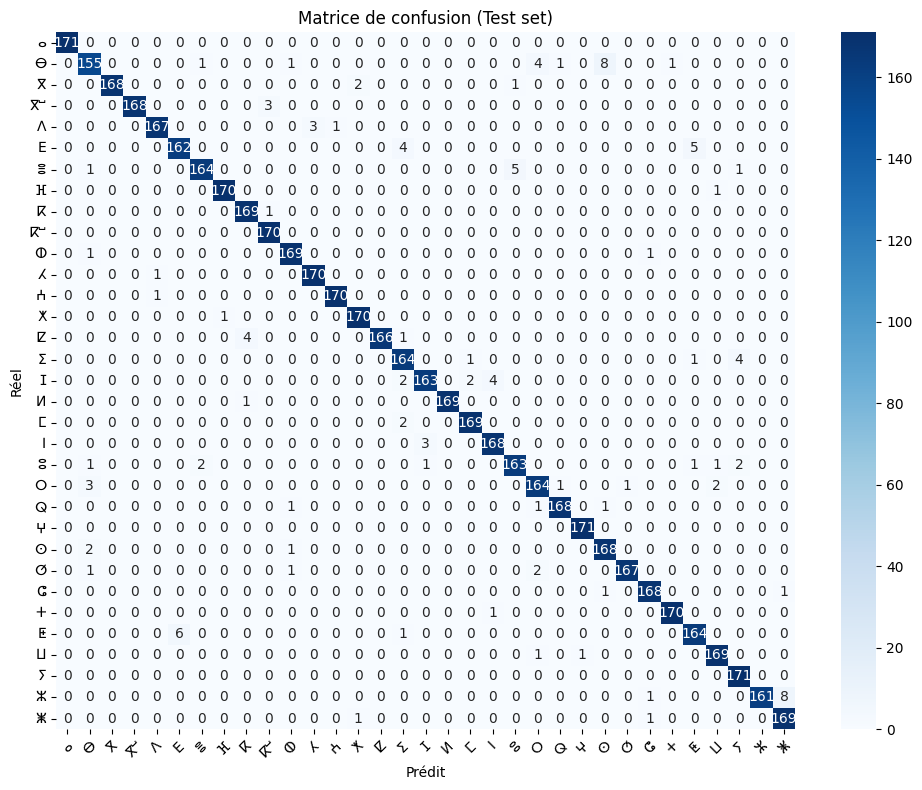

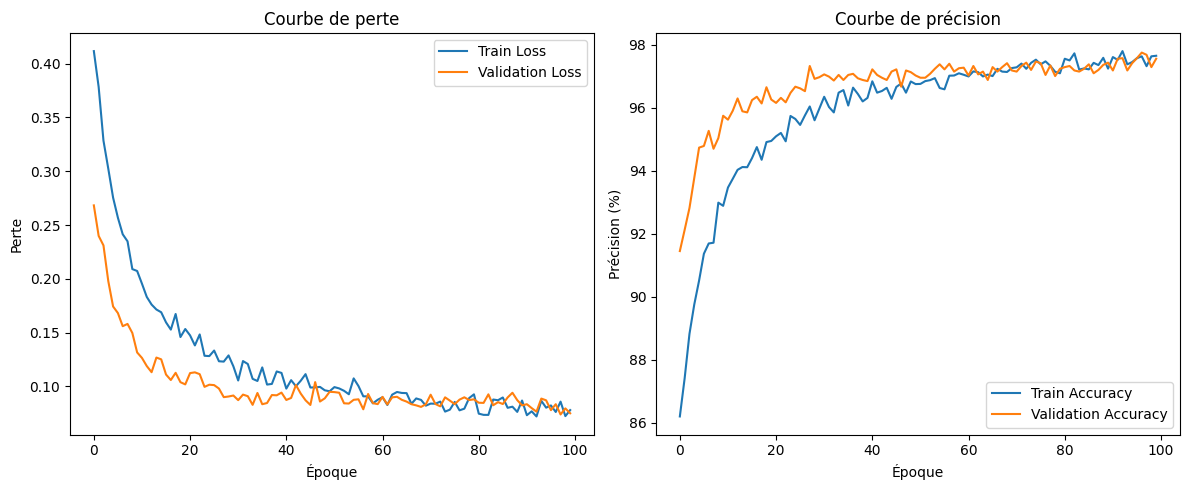

In [14]:
# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion (Test set)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_pytorch.png')
plt.show()

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_pytorch.png')
plt.show()

In [15]:
# Sauvegarder le modèle
torch.save(model.state_dict(), 'tifinagh_mlp_pytorch.pth')
print("Modèle sauvegardé sous 'tifinagh_mlp_pytorch.pth'")

# Nettoyer la mémoire GPU
torch.cuda.empty_cache()

Modèle sauvegardé sous 'tifinagh_mlp_pytorch.pth'


**Avec RGB**

In [9]:
# Définir le chemin vers le dossier décompressé
data_dir = '/kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_64'
print(f"Data directory: {data_dir}")

# Fonction pour corriger les chemins d'images problématiques
def correct_image_path(path):
    # Supprimer les duplications de répertoires
    path = re.sub(r'(AMHCD_64/)+', '', path)
    
    # Supprimer './' au début du chemin
    if path.startswith('./'):
        path = path[2:]
    
    # Reconstruire le chemin correct
    base_dir = '/kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_64'
    if not path.startswith(base_dir):
        path = os.path.join(base_dir, path)
    
    return path

# Charger le fichier CSV contenant les étiquettes
try:
    # Read the CSV file
    labels_df = pd.read_csv(os.path.join(data_dir, 'new-labels-map.csv'), 
                           header=None, names=['image_path', 'label'])
    
    # Corriger les chemins d'images
    labels_df['image_path'] = labels_df['image_path'].apply(correct_image_path)
    
    print("DataFrame preview after path correction:")
    print(labels_df.head())
    
    # Vérifier que les chemins existent
    valid_paths = []
    valid_labels = []
    
    for idx, row in labels_df.iterrows():
        if os.path.exists(row['image_path']):
            valid_paths.append(row['image_path'])
            valid_labels.append(row['label'])
        else:
            print(f"Warning: Path does not exist: {row['image_path']}")
    
    labels_df = pd.DataFrame({'image_path': valid_paths, 'label': valid_labels})
    
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, \
           "CSV must contain 'image_path' and 'label' columns"
           
except Exception as e:
    print(f"Error reading CSV: {e}")
    # Alternative: construire un DataFrame à partir des dossiers
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp')):
                    img_path = os.path.join(label_path, img_name)
                    if os.path.exists(img_path):
                        image_paths.append(img_path)
                        labels.append(label_dir)
                    else:
                        print(f"Warning: Path does not exist: {img_path}")
    
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    print(f"Created DataFrame from directory structure with {len(labels_df)} samples")

# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

Data directory: /kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_64
DataFrame preview after path correction:
                                          image_path label
0  /kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_6...     ⴰ
1  /kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_6...     ⴰ
2  /kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_6...     ⴰ
3  /kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_6...     ⴰ
4  /kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_6...     ⴰ
Loaded 25740 samples with 33 unique classes.


In [10]:
# Fonction pour calculer mean et std
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean.numpy(), std.numpy()  # Convertir en numpy arrays



In [12]:
# Classe Dataset pour calculer mean et std (sans normalisation)
class TifinaghDatasetTemp(Dataset):
    def __init__(self, image_paths, labels, mode='rgb'):
        self.image_paths = image_paths
        self.labels = labels
        self.mode = mode
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            if self.mode == 'grayscale':
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    raise ValueError(f"Could not load image: {img_path}")
                image = cv2.resize(image, TARGET_SIZE)
                image = image.astype(np.float32) / 255.0
                image = np.expand_dims(image, axis=0)
            else:  # RGB
                image = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if image is None:
                    raise ValueError(f"Could not load image: {img_path}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, TARGET_SIZE)
                image = image.astype(np.float32) / 255.0
                image = np.transpose(image, (2, 0, 1))
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            if self.mode == 'grayscale':
                image = np.zeros((1, *TARGET_SIZE), dtype=np.float32)
            else:
                image = np.zeros((3, *TARGET_SIZE), dtype=np.float32)
        
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [13]:
# Classe Dataset avec normalisation (version corrigée)
class TifinaghDataset(Dataset):
    def __init__(self, image_paths, labels, mode='rgb', mean=None, std=None):
        self.image_paths = image_paths
        self.labels = labels
        self.mode = mode
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            if self.mode == 'grayscale':
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    raise ValueError(f"Could not load image: {img_path}")
                image = cv2.resize(image, TARGET_SIZE)
                image = image.astype(np.float32) / 255.0
                image = np.expand_dims(image, axis=0)
            else:  # RGB
                image = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if image is None:
                    raise ValueError(f"Could not load image: {img_path}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, TARGET_SIZE)
                image = image.astype(np.float32) / 255.0
                image = np.transpose(image, (2, 0, 1))
                
                # Appliquer la normalisation avec des numpy arrays
                if self.mean is not None and self.std is not None:
                    image = (image - self.mean[:, None, None]) / self.std[:, None, None]
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            if self.mode == 'grayscale':
                image = np.zeros((1, *TARGET_SIZE), dtype=np.float32)
            else:
                image = np.zeros((3, *TARGET_SIZE), dtype=np.float32)
                if self.mean is not None and self.std is not None:
                    image = (image - self.mean[:, None, None]) / self.std[:, None, None]
        
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [14]:
IMAGE_MODE='rgb'
# Préparer les données
image_paths = labels_df['image_path'].values
labels = labels_df['label_encoded'].values

# Diviser en ensembles d'entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Créer un dataset temporaire pour calculer mean et std
train_dataset_temp = TifinaghDatasetTemp(X_train, y_train, mode=IMAGE_MODE)
train_loader_temp = DataLoader(train_dataset_temp, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Calculer mean et std
train_mean, train_std = compute_mean_std(train_loader_temp)
print(f"Mean: {train_mean}, Std: {train_std}")

# Créer les datasets avec normalisation
train_dataset = TifinaghDataset(X_train, y_train, mode=IMAGE_MODE, mean=train_mean, std=train_std)
val_dataset = TifinaghDataset(X_val, y_val, mode=IMAGE_MODE, mean=train_mean, std=train_std)
test_dataset = TifinaghDataset(X_test, y_test, mode=IMAGE_MODE, mean=train_mean, std=train_std)

# Créer les DataLoaders avec optimisation pour GPU
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Mean: [0.92735016 0.92678106 0.94686157], Std: [0.13317803 0.13886842 0.10038368]


In [15]:
# Calculer la taille d'entrée
if IMAGE_MODE == 'grayscale':
    input_size = TARGET_SIZE[0] * TARGET_SIZE[1]
else:
    input_size = TARGET_SIZE[0] * TARGET_SIZE[1] * 3

# Initialiser le modèle avec support multi-GPU
model = TifinaghMLP(input_size, num_classes)

# Utiliser multi-GPU si disponible
if torch.cuda.device_count() > 1:
    print(f"Utilisation de {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(DEVICE)

# Initialiser la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initialiser le scaler pour mixed precision training
scaler = GradScaler()

Utilisation de 2 GPUs!


/tmp/ipykernel_36/2447033918.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Entraînement avec mixed precision
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Phase d'entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass avec scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Phase de validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Afficher l'utilisation de la mémoire GPU
        if torch.cuda.is_available():
            print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

/tmp/ipykernel_36/2619919109.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return F.linear(input, self.weight, self.bias)


Epoch [1/100], Train Loss: 0.7361, Train Acc: 78.63%, Val Loss: 0.2527, Val Acc: 92.52%
GPU Memory allocated: 0.04 GB
Epoch [11/100], Train Loss: 0.1579, Train Acc: 95.60%, Val Loss: 0.1949, Val Acc: 95.34%
GPU Memory allocated: 0.04 GB
Epoch [21/100], Train Loss: 0.1707, Train Acc: 96.19%, Val Loss: 0.2420, Val Acc: 95.67%
GPU Memory allocated: 0.04 GB
Epoch [31/100], Train Loss: 0.1350, Train Acc: 97.24%, Val Loss: 0.2452, Val Acc: 96.27%
GPU Memory allocated: 0.04 GB
Epoch [41/100], Train Loss: 0.1279, Train Acc: 97.68%, Val Loss: 0.3200, Val Acc: 95.67%
GPU Memory allocated: 0.04 GB
Epoch [51/100], Train Loss: 0.1257, Train Acc: 97.87%, Val Loss: 0.2985, Val Acc: 96.37%
GPU Memory allocated: 0.04 GB
Epoch [61/100], Train Loss: 0.1679, Train Acc: 97.79%, Val Loss: 0.3961, Val Acc: 96.29%
GPU Memory allocated: 0.04 GB
Epoch [71/100], Train Loss: 0.1703, Train Acc: 97.95%, Val Loss: 0.4567, Val Acc: 95.92%
GPU Memory allocated: 0.04 GB
Epoch [81/100], Train Loss: 0.1493, Train Acc: 98

In [18]:
# Nettoyer la mémoire GPU
torch.cuda.empty_cache()

In [19]:
# Évaluation sur l'ensemble de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [20]:
# Calcul des métriques
print("\nRapport de classification (Test set):")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Rapport de classification (Test set):
              precision    recall  f1-score   support

           ⴰ       0.99      1.00      0.99       156
           ⴱ       0.97      0.99      0.98       156
           ⴳ       0.96      0.96      0.96       156
          ⴳⵯ       0.99      0.97      0.98       156
           ⴷ       0.97      0.99      0.98       156
           ⴹ       0.91      0.89      0.90       156
           ⴻ       0.99      0.93      0.96       156
           ⴼ       0.97      0.98      0.98       156
           ⴽ       0.98      0.96      0.97       156
          ⴽⵯ       0.99      0.97      0.98       156
           ⵀ       0.94      0.97      0.96       156
           ⵃ       0.96      0.98      0.97       156
           ⵄ       0.99      0.96      0.98       156
           ⵅ       0.94      0.96      0.95       156
           ⵇ       0.98      0.96      0.97       156
           ⵉ       0.94      0.97      0.96       156
           ⵊ       0.97      0.98      0.9

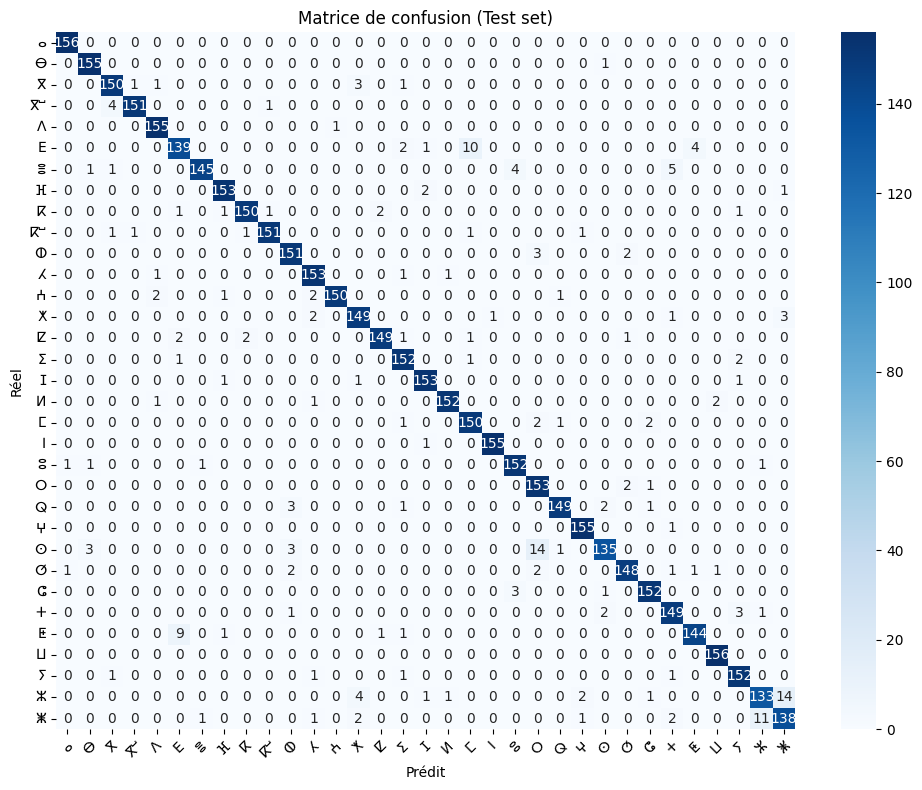

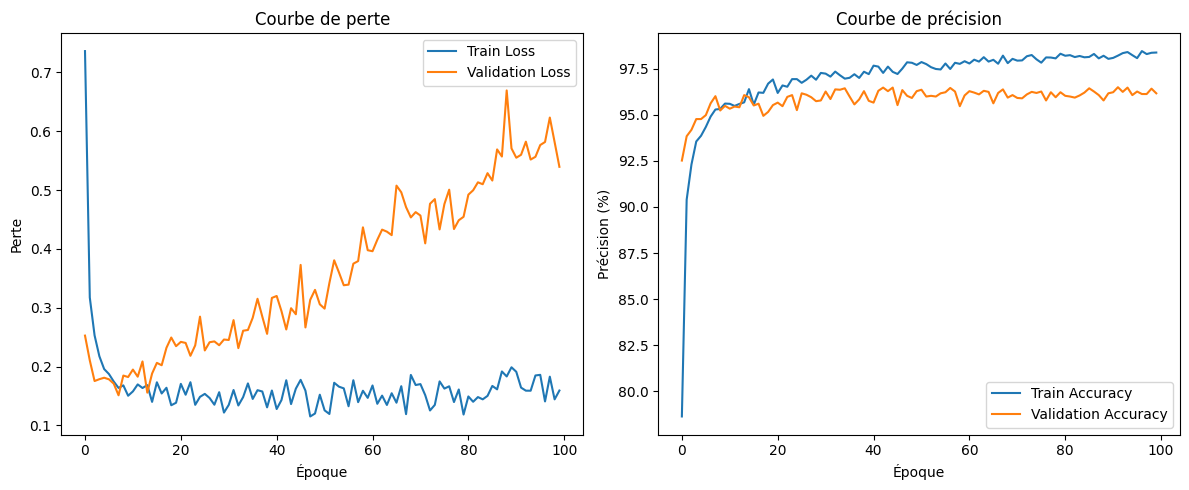

In [21]:
# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion (Test set)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_pytorch.png')
plt.show()

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_pytorch.png')
plt.show()

In [22]:
# Sauvegarder le modèle
torch.save(model.state_dict(), 'tifinagh_mlp_pytorch_rgb.pth')
print("Modèle sauvegardé sous 'tifinagh_mlp_pytorch_rgb.pth'")

# Nettoyer la mémoire GPU
torch.cuda.empty_cache()

Modèle sauvegardé sous 'tifinagh_mlp_pytorch_rgb.pth'


# **TP-CNN-Lenet 5**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paramètres
TARGET_SIZE = (32, 32)
BATCH_SIZE = 64
EPOCHS = 100
LR = 0.001
USE_RGB = False # Set to False for grayscale


Using device: cuda


In [3]:
# Chargement et prétraitement des données
data_dir = '/kaggle/input/amhcd-gryscale/amhcd-data-64/tifinagh-images'
csv_path = os.path.join(data_dir, '/kaggle/input/amhcd-gryscale/amhcd-data-64/labels-map.csv')

df = pd.read_csv(csv_path, header=None, names=['rel_path', 'glyph'], dtype=str, encoding='utf-8')

def make_full_path(rel_p):
    p = Path(rel_p.lstrip('./'))
    sub = p.parts[-2:]
    return os.path.join(data_dir, *sub)

df['image_path'] = df['rel_path'].apply(make_full_path)

# Vérification des fichiers manquants
missing = df.loc[~df['image_path'].apply(os.path.exists), 'image_path']
if not missing.empty:
    raise FileNotFoundError("Fichiers introuvables :\n" + "\n".join(missing.tolist()))

print(f"✅ Chargé {len(df)} images, {df['glyph'].nunique()} classes.")

# Encodage des labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['glyph'])
num_classes = len(le.classes_)

def load_and_preprocess_image(image_path, target_size=TARGET_SIZE, use_rgb=USE_RGB):
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB if use_rgb else cv2.COLOR_BGR2GRAY)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

X = np.stack([load_and_preprocess_image(p, use_rgb=USE_RGB) for p in df['image_path']])
y = df['label_enc'].values

# Reshape pour PyTorch (N, H, W, C) -> (N, C, H, W)
X = np.transpose(X, (0, 3, 1, 2)) if USE_RGB else X[:, np.newaxis, :, :]

# Split des données
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

✅ Chargé 28182 images, 33 classes.
Train=16908, Val=5637, Test=5637


In [4]:
# Conversion en tensors PyTorch
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.LongTensor(y_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

# Datasets et DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [5]:
# Définition du modèle LeNet5 avec PyTorch
class LeNet5(nn.Module):
    def __init__(self, num_classes=33, in_channels=3):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
# Initialisation du modèle
model = LeNet5(num_classes=num_classes, in_channels=3 if USE_RGB else 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
# Boucle d'entraînement
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch 0, Train Loss: 2.1405, Val Loss: 1.3413, Train Acc: 38.0707, Val Acc: 59.5175
Epoch 10, Train Loss: 0.1512, Val Loss: 0.2475, Train Acc: 94.8131, Val Acc: 91.7687
Epoch 20, Train Loss: 0.0763, Val Loss: 0.2116, Train Acc: 97.4036, Val Acc: 93.9684
Epoch 30, Train Loss: 0.0301, Val Loss: 0.1257, Train Acc: 99.0714, Val Acc: 96.3456
Epoch 40, Train Loss: 0.0326, Val Loss: 0.1712, Train Acc: 99.0300, Val Acc: 96.0972
Epoch 50, Train Loss: 0.0291, Val Loss: 0.1796, Train Acc: 99.0951, Val Acc: 95.7602
Epoch 60, Train Loss: 0.0517, Val Loss: 0.1565, Train Acc: 98.4268, Val Acc: 96.0440
Epoch 70, Train Loss: 0.0078, Val Loss: 0.0939, Train Acc: 99.7871, Val Acc: 97.5164
Epoch 80, Train Loss: 0.0259, Val Loss: 0.1254, Train Acc: 99.2430, Val Acc: 97.2326
Epoch 90, Train Loss: 0.0027, Val Loss: 0.0735, Train Acc: 99.9349, Val Acc: 98.1728



=== Classification Report (Test) ===
              precision    recall  f1-score   support

           ⴰ       0.97      1.00      0.98       171
           ⴱ       0.92      0.93      0.93       171
           ⴳ       0.99      0.97      0.98       171
          ⴳⵯ       0.98      0.96      0.97       171
           ⴷ       0.98      0.99      0.99       171
           ⴹ       0.94      0.86      0.90       171
           ⴻ       0.93      0.95      0.94       171
           ⴼ       0.99      0.99      0.99       171
           ⴽ       0.98      0.99      0.99       170
          ⴽⵯ       0.97      0.99      0.98       170
           ⵀ       0.98      0.98      0.98       171
           ⵃ       0.99      0.98      0.99       171
           ⵄ       0.99      0.99      0.99       171
           ⵅ       0.99      0.99      0.99       171
           ⵇ       0.99      0.98      0.99       171
           ⵉ       0.95      0.99      0.97       170
           ⵊ       0.97      0.96      0.96

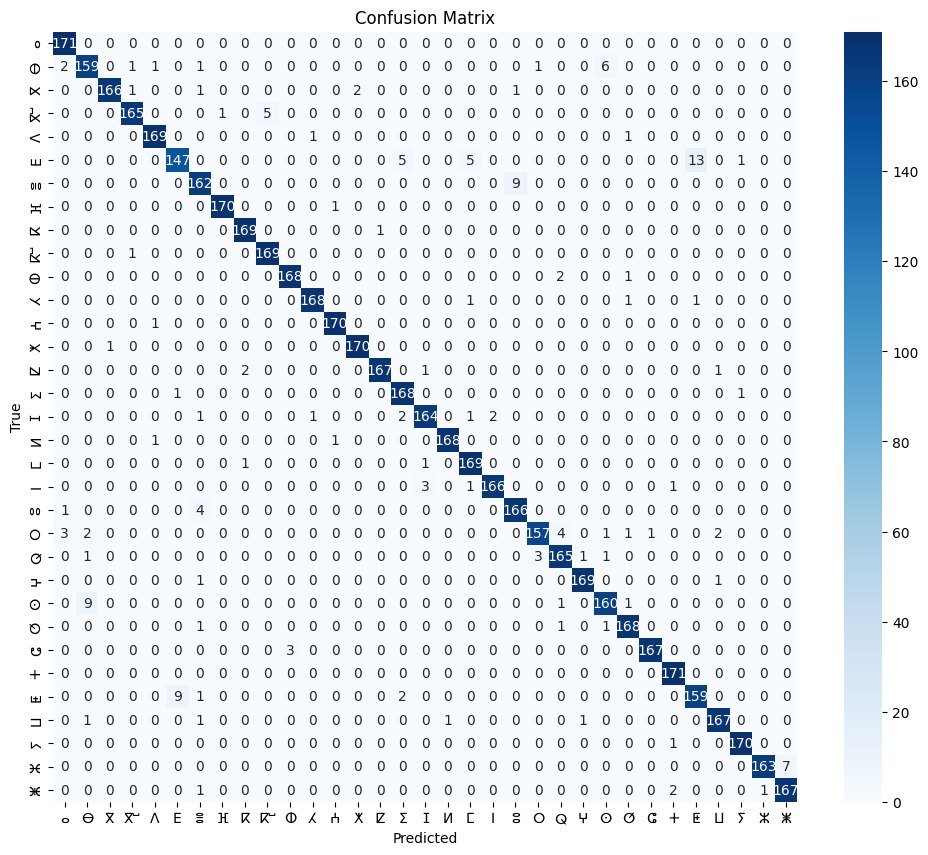

In [8]:
# Évaluation sur le test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = output.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print("\n=== Classification Report (Test) ===")
print(classification_report(all_targets, all_preds, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

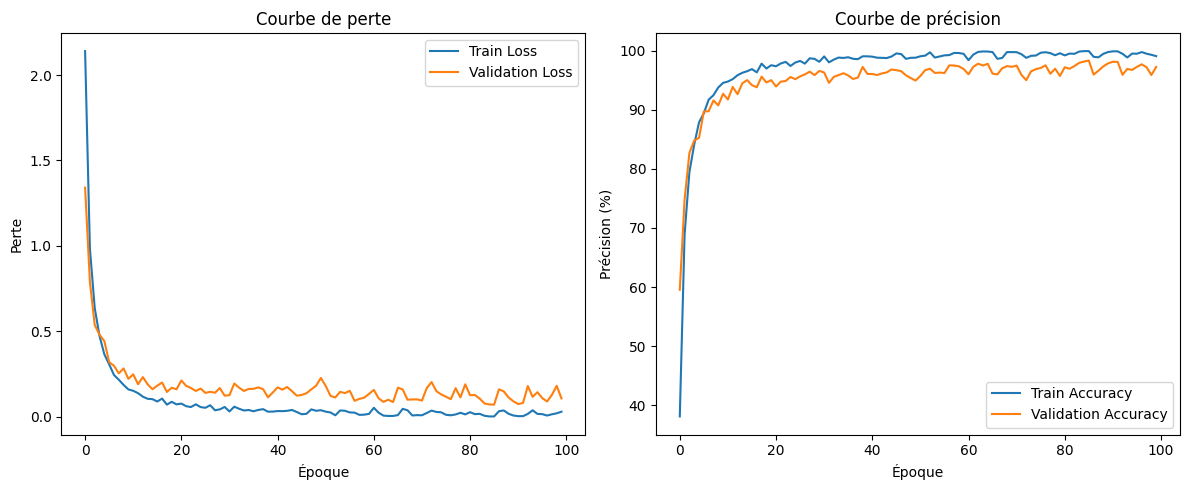

In [9]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_pytorch.png')
plt.show()

**RGB**

In [10]:
USE_RGB = True

# Chargement et prétraitement des données
data_dir = '/kaggle/input/amhcd-rgb/amhcd/AMHCD_64/AMHCD_64'
csv_path = os.path.join(data_dir, 'new-labels-map.csv')

df = pd.read_csv(csv_path, header=None, names=['rel_path', 'glyph'], dtype=str, encoding='utf-8')

def make_full_path(rel_p):
    p = Path(rel_p.lstrip('./'))
    sub = p.parts[-2:]
    return os.path.join(data_dir, *sub)

df['image_path'] = df['rel_path'].apply(make_full_path)

# Vérification des fichiers manquants
missing = df.loc[~df['image_path'].apply(os.path.exists), 'image_path']
if not missing.empty:
    raise FileNotFoundError("Fichiers introuvables :\n" + "\n".join(missing.tolist()))

print(f"✅ Chargé {len(df)} images, {df['glyph'].nunique()} classes.")

# Encodage des labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['glyph'])
num_classes = len(le.classes_)

def load_and_preprocess_image(image_path, target_size=TARGET_SIZE, use_rgb=USE_RGB):
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB if use_rgb else cv2.COLOR_BGR2GRAY)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

X = np.stack([load_and_preprocess_image(p, use_rgb=USE_RGB) for p in df['image_path']])
y = df['label_enc'].values

# Reshape pour PyTorch (N, H, W, C) -> (N, C, H, W)
X = np.transpose(X, (0, 3, 1, 2)) if USE_RGB else X[:, np.newaxis, :, :]

# Split des données
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

✅ Chargé 25740 images, 33 classes.
Train=15444, Val=5148, Test=5148


In [11]:
# Conversion en tensors PyTorch
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.LongTensor(y_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

# Datasets et DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
# Initialisation du modèle
model = LeNet5(num_classes=num_classes, in_channels=3 if USE_RGB else 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [13]:
# Boucle d'entraînement
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch 0, Train Loss: 2.8032, Val Loss: 1.4740, Train Acc: 20.4610, Val Acc: 56.0606
Epoch 10, Train Loss: 0.2036, Val Loss: 0.2470, Train Acc: 94.0041, Val Acc: 93.2401
Epoch 20, Train Loss: 0.0932, Val Loss: 0.1537, Train Acc: 96.9697, Val Acc: 95.8430
Epoch 30, Train Loss: 0.0535, Val Loss: 0.1585, Train Acc: 98.1805, Val Acc: 95.6682
Epoch 40, Train Loss: 0.0306, Val Loss: 0.1451, Train Acc: 98.9834, Val Acc: 96.9697
Epoch 50, Train Loss: 0.0292, Val Loss: 0.1398, Train Acc: 99.0676, Val Acc: 96.9114
Epoch 60, Train Loss: 0.0209, Val Loss: 0.1411, Train Acc: 99.3007, Val Acc: 97.2222
Epoch 70, Train Loss: 0.0068, Val Loss: 0.1523, Train Acc: 99.8057, Val Acc: 97.3388
Epoch 80, Train Loss: 0.0067, Val Loss: 0.1356, Train Acc: 99.7798, Val Acc: 97.7273
Epoch 90, Train Loss: 0.0023, Val Loss: 0.1477, Train Acc: 99.9288, Val Acc: 97.7078



=== Classification Report (Test) ===
              precision    recall  f1-score   support

           ⴰ       0.99      1.00      1.00       156
           ⴱ       0.99      1.00      0.99       156
           ⴳ       0.96      0.98      0.97       156
          ⴳⵯ       0.97      0.98      0.98       156
           ⴷ       0.98      0.99      0.98       156
           ⴹ       0.99      0.96      0.97       156
           ⴻ       0.99      0.97      0.98       156
           ⴼ       0.99      0.98      0.99       156
           ⴽ       0.98      0.96      0.97       156
          ⴽⵯ       0.97      0.98      0.97       156
           ⵀ       0.99      0.97      0.98       156
           ⵃ       0.97      0.97      0.97       156
           ⵄ       0.99      0.98      0.98       156
           ⵅ       0.99      0.97      0.98       156
           ⵇ       0.99      0.99      0.99       156
           ⵉ       0.98      0.98      0.98       156
           ⵊ       0.99      0.99      0.99

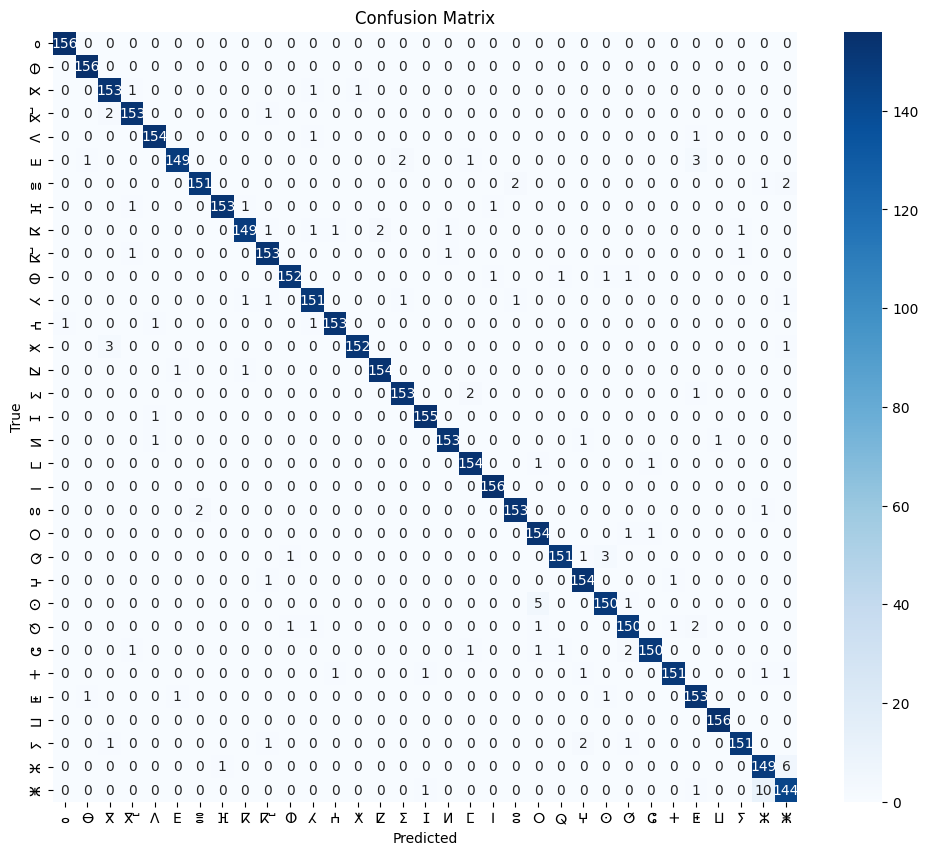

In [14]:
# Évaluation sur le test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = output.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print("\n=== Classification Report (Test) ===")
print(classification_report(all_targets, all_preds, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

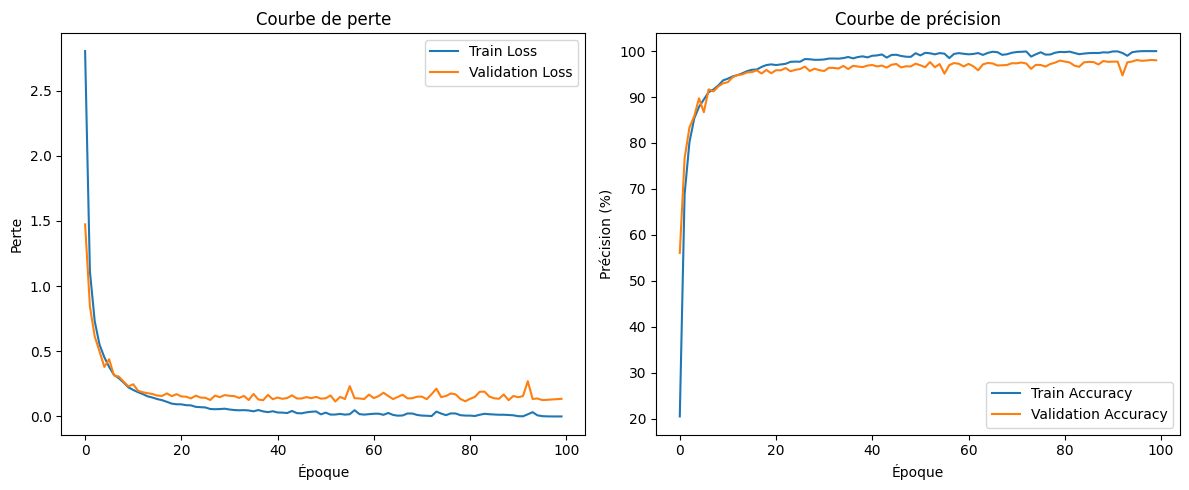

In [15]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_pytorch.png')
plt.show()